In [115]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import math
from xfoil import XFoil
from xfoil.model import Airfoil
from scipy.interpolate import CubicSpline
from scipy.special import comb
from deap import base, creator, tools, algorithms
from xfoil.test import naca0012

# Define the airfoil function
n_ctr_pts = 10
angle_attack = 10
n_times = 120
n_iter = 70  # Number of iterations of the bayesian 
init_size = 100
max_iterations= 100
n_restarts = 25
# Genetic Algorithm parameters
population_size = 100
max_generations = 200
mach = 0.15
re = 1e6
std_x = [naca0012.x[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [1]
std_y = [naca0012.y[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [0]


In [117]:

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def airfoil(h, n_ctr_pts=n_ctr_pts, chord=naca0012.x, nTimes=n_times):
    top_half = [(x, y) for x, y in zip(chord[:n_ctr_pts], h[0])] 
    low_half = [(x, -y) for x, y in zip(chord[n_ctr_pts:], h[1])]
    pts =  top_half +  low_half  # Include leading and trailing edges
    pts = np.array(pts)
    x = np.append(pts[:, 0][:-1], pts[:, 0][0])
    y = np.append(pts[:, 1][:-1], pts[:, 1][0])
    t = np.linspace(0.0, 1, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, n_ctr_pts*2-1, t) for i in range(0, n_ctr_pts*2)   ])
    xvals = np.dot(x, polynomial_array)
    yvals = np.dot(y, polynomial_array)
    pts = np.column_stack([xvals, yvals])
    #plot_foil(pts)
    """plt.figure(figsize=(10, 5))
    plt.scatter(x[0], y[0],  color='r', marker='o')
    plt.scatter(x[-1], y[-1])
    plt.plot(x,y)
    plt.plot(xvals, yvals)
    plt.grid(True)"""
    return pts, Airfoil(x=xvals, y=yvals)

def plot_foil(pts, std_points=[naca0012.x, naca0012.y]):
    # Extract x and y coordinates for plotting
    x, y = pts[:, 0], pts[:, 1]
    # Plot the airfoil shape
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Airfoil Shape', color='b', marker='o')
    plt.fill(x, y, 'b', alpha=0.3)  # Fill the shape for better visualization
    plt.plot(std_points[0], std_points[1], label='NACA0012', color='r', marker='o')
    plt.fill(std_points[0], std_points[1], 'r', alpha=0.3)
    # Adding labels and legend
    plt.xlabel('Chord Position')
    plt.ylabel('Height')
    plt.title('Airfoil Shape')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [118]:
def fitness(air):
    xf = XFoil()
    xf.airfoil = air
    xf.Re = re
    xf.mach = mach
    xf.max_iter = 100
    cl, cd, cm, cp = xf.a(angle_attack)
    return cl, cd

In [119]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil(individual):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis

    cl, cd, cm, cp = xf.a(angle_attack)
    if math.isnan(cl) or math.isnan(cd):
        return 0, 10e5
    else:
        # Return Cl and Cd
        return cl, cd


In [120]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil_angle_attacks(individual, min=-20, max=20, step=1):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)

    # Return Cl and -Cd (minimize Cd -> maximize -Cd)
    return a, cl, cd


In [121]:
def naca_eval(min=-20, max=20, step=1):
    xf = XFoil()
    xf.airfoil = naca0012
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)
    return a, cl, cd

In [122]:


# GPModel class for Gaussian Process Regression
class GPModel:
    def __init__(self, kernel=None):
        if kernel is None:
            kernel = Matern(nu=2.5)
        self.gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    def fit(self, X, y):
        self.gp.fit(X, y)

    def predict(self, X):
        return self.gp.predict(X, return_std=True)

# Acquisition function for multi-objective optimization
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X)
    mu_sample = gpr.predict(X_sample)

    mu_sample_opt = np.max(Y_sample)  # Optimal value in Y_sample for each objective

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei.flatten()

# Propose location for next evaluation
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(1, -1), X_sample, Y_sample, gpr)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(1, -1)

def is_dominated(point, others):
    for other in others:
        if (other[0] > point[0] and other[1] < point[1]) or (other[0] >= point[0] and other[1] <= point[1] and not np.array_equal(point, other)):
            return True
    return False

def pareto_front_with_indexes(points):
    pareto_points = []
    pareto_indexes = []
    for index, point in enumerate(points):
        if not is_dominated(point, np.delete(points, index, axis=0)):
            pareto_points.append(point)
            pareto_indexes.append(index)
    return np.array(pareto_points), np.array(pareto_indexes)
# Multi-objective Bayesian Optimization


# Define the bounds of the search space (0 to 0.1 for each element in h)
bounds = np.array([[0, 0.1]] * (n_ctr_pts * 2))
X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(init_size, bounds.shape[0]))
Y_sample = np.array([evaluate_airfoil(ind) for ind in X_sample])

gp_cl = GPModel()
gp_cd = GPModel()
gp_cl.fit(X_sample, Y_sample[:, 0].reshape(-1, 1))
gp_cd.fit(X_sample, Y_sample[:, 1].reshape(-1, 1))

for i in range(n_iter):
    X_next = propose_location(expected_improvement, X_sample, Y_sample[:, 0], gp_cl, bounds, n_restarts)
    Y_next = evaluate_airfoil(X_next.flatten())
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    gp_cl.fit(X_sample, Y_sample[:, 0].reshape(-1, 1))
    gp_cd.fit(X_sample, Y_sample[:, 1].reshape(-1, 1))

    print(f"Iteration {i+1}: Cl - {Y_sample[:, 0].max()}, Cd - {Y_sample[:, 1].min()}")




Iteration 1: Cl - 1.0771682262420654, Cd - 0.006482633762061596
Iteration 2: Cl - 1.0771682262420654, Cd - 0.006482633762061596
Iteration 3: Cl - 1.0771682262420654, Cd - 0.006482633762061596
Iteration 4: Cl - 1.0771682262420654, Cd - 0.006482633762061596
Iteration 5: Cl - 1.0854054689407349, Cd - 0.006482633762061596
Iteration 6: Cl - 1.1257481575012207, Cd - 0.006482633762061596
Iteration 7: Cl - 1.1257481575012207, Cd - 0.006482633762061596
Iteration 8: Cl - 1.1257481575012207, Cd - 0.006482633762061596
Iteration 9: Cl - 1.1257481575012207, Cd - 0.006482633762061596
Iteration 10: Cl - 1.1816803216934204, Cd - 0.006482633762061596
Iteration 11: Cl - 1.1816803216934204, Cd - 0.006482633762061596
Iteration 12: Cl - 1.1816803216934204, Cd - 0.006482633762061596
Iteration 13: Cl - 1.1816803216934204, Cd - 0.006482633762061596
Iteration 14: Cl - 1.1816803216934204, Cd - 0.006482633762061596
Iteration 15: Cl - 1.1816803216934204, Cd - 0.006482633762061596
Iteration 16: Cl - 1.1816803216934

In [123]:
pareto_points, pareto_indexes = pareto_front_with_indexes(Y_sample)
print("Pareto front points:")
print(pareto_points)


Pareto front points:
[[0.52455252 0.01074531]
 [0.62717676 0.01091514]
 [0.51929915 0.0103248 ]
 [0.81882787 0.01164794]
 [0.72998416 0.011123  ]
 [0.50809556 0.00944878]
 [0.98184562 0.01217689]
 [0.43967065 0.00897287]
 [0.4076823  0.00840882]
 [0.12490118 0.00637561]
 [1.15253031 0.01381765]
 [1.26460588 0.01423669]]


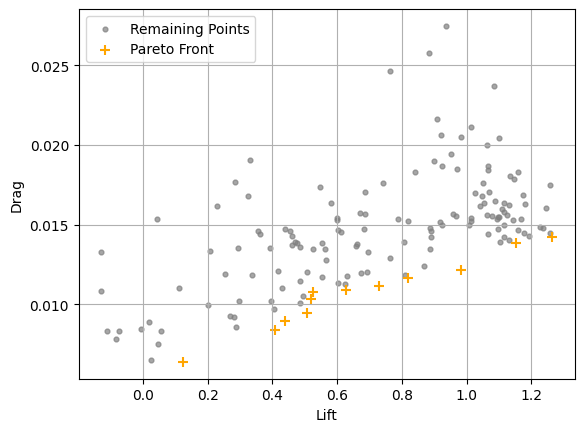

In [124]:

# Combine the lists into a list of points
points = []
for i in Y_sample:
    if i[1] != 10e5:
        points.append(i)

# Find the Pareto front
pareto = pareto_points

# Separate the Pareto front points
pareto_l = [p[0] for p in pareto]
pareto_d = [p[1] for p in pareto]

# Remove Pareto front points from lifts and drags
remaining_points = [p for p in points if p not in pareto]
remaining_l = [p[0] for p in remaining_points]
remaining_d = [p[1] for p in remaining_points]

# Plotting
plt.figure()
plt.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.7, label="Remaining Points")
plt.scatter(pareto_l, pareto_d, color="orange", marker='+',s=50, label="Pareto Front")
plt.xlabel("Lift")
plt.ylabel("Drag")
plt.legend()
plt.grid(True)
plt.show()


## Pareto front results

#### Section 1
ploting the Airfoils that give a better drag and lift compared to the NACA0012
#### Section 2
plotting all the pareto front individuals

## Section 1

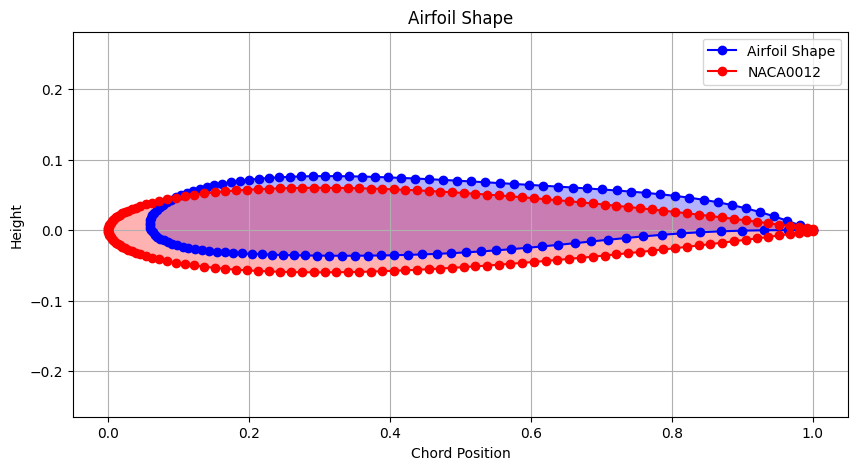

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 1.152530312538147, drag : -0.013817645609378815
Direction 1.00, lift improvement 6.62%, drag improvement 7.74%


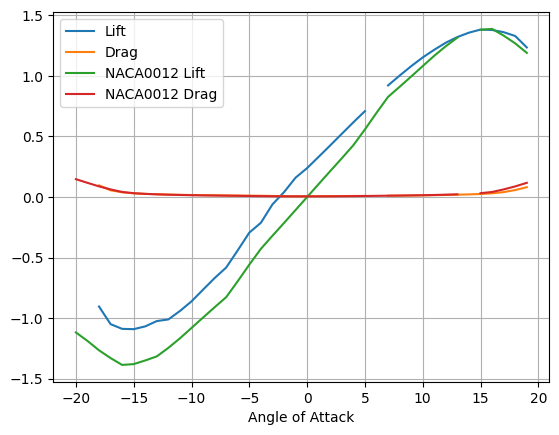

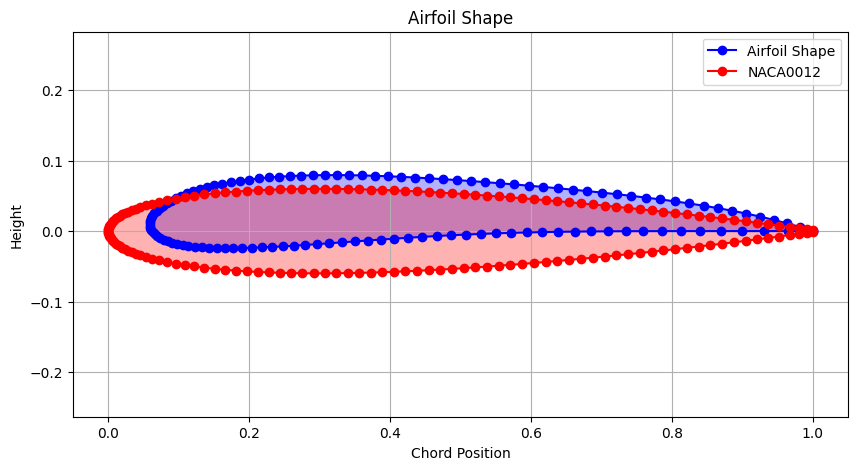

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 1.2646058797836304, drag : -0.01423669420182705
Direction 1.00, lift improvement 16.99%, drag improvement 4.94%


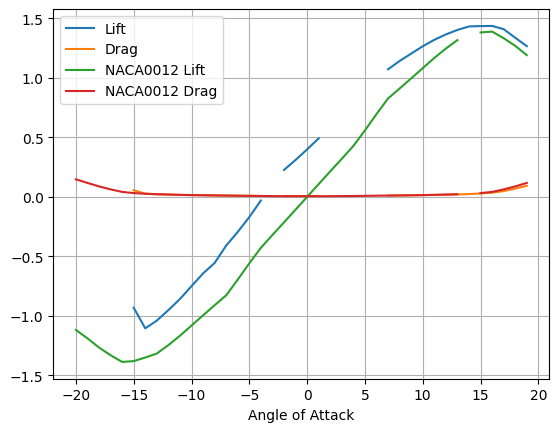

In [125]:
naca_a, naca_cl, naca_cd = naca_eval()

for i in pareto_indexes:
    if Y_sample[i][0] != 0 and Y_sample[i][1] != -1e5:
        ind = X_sample[i]
        fit = Y_sample[i]
        best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
        best, foil = airfoil(best_indiv, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)

        direction = fit[0] / abs(fit[0])
        naca0012_fit = np.array(fitness(naca0012))

        lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
        drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100

        if lift_improvement > 0 and drag_improvement > 0:
            plot_foil(best)
            a, cl, cd = evaluate_airfoil_angle_attacks(ind)

            plt.figure()
            plt.plot(a, cl, label="Lift")
            plt.plot(a, cd, label="Drag")
            plt.plot(naca_a, naca_cl, label="NACA0012 Lift")
            plt.plot(naca_a, naca_cd, label="NACA0012 Drag")
            plt.legend()
            plt.xlabel("Angle of Attack")
            plt.grid(True)

            print(f"NACA0012 fitness : lift {naca0012_fit[0]}, drag : {naca0012_fit[1]}")
            print(f"Best individual fitness : lift {fit[0]}, drag : {-fit[1]}")
            print(f"Direction {direction:.2f}, lift improvement {lift_improvement:.2f}%, drag improvement {drag_improvement:.2f}%")


## Section 2

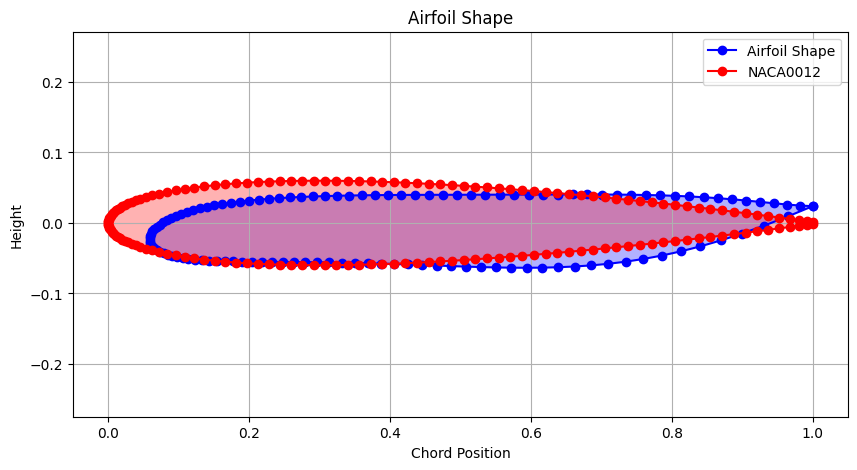

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.5245525240898132, drag : -0.010745312087237835
Direction 1.00, lift improvement -51.47%, drag improvement 28.26%


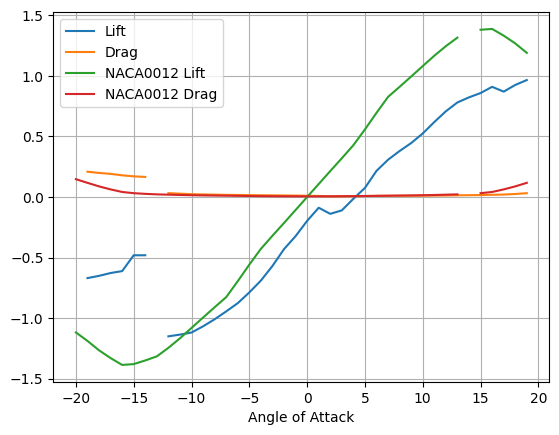

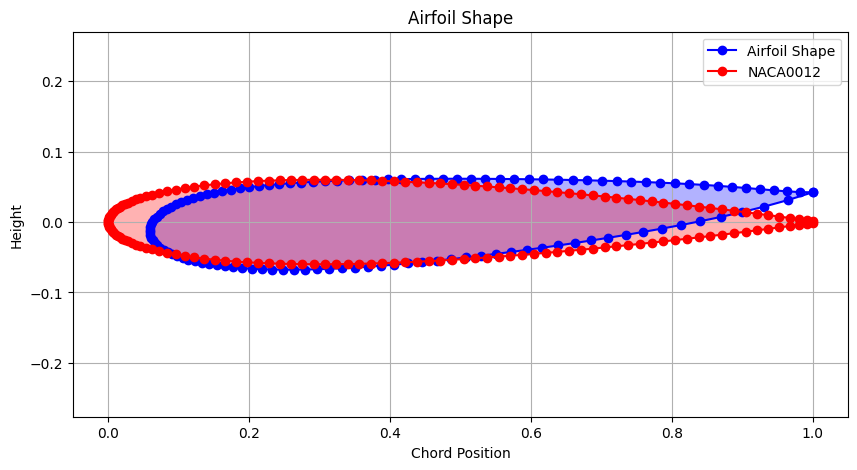

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.6271767616271973, drag : -0.010915138758718967
Direction 1.00, lift improvement -41.98%, drag improvement 27.12%


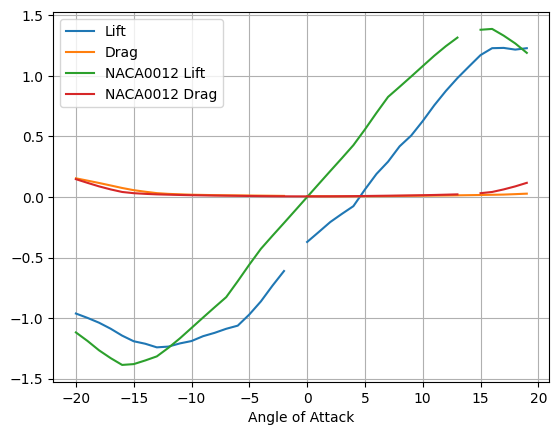

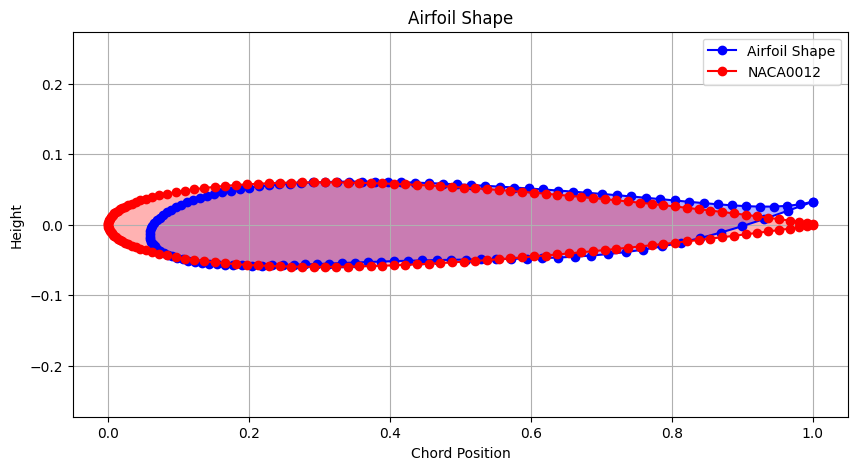

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.5192991495132446, drag : -0.010324795730412006
Direction 1.00, lift improvement -51.96%, drag improvement 31.06%


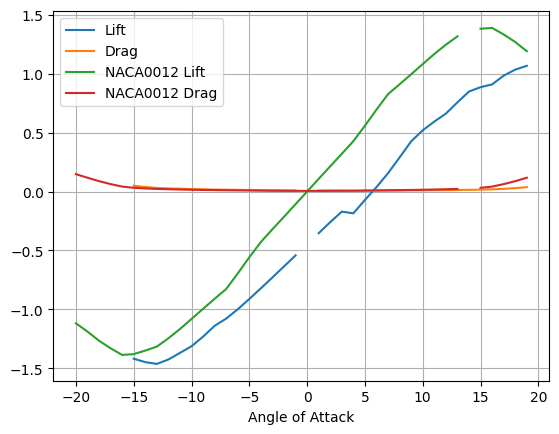

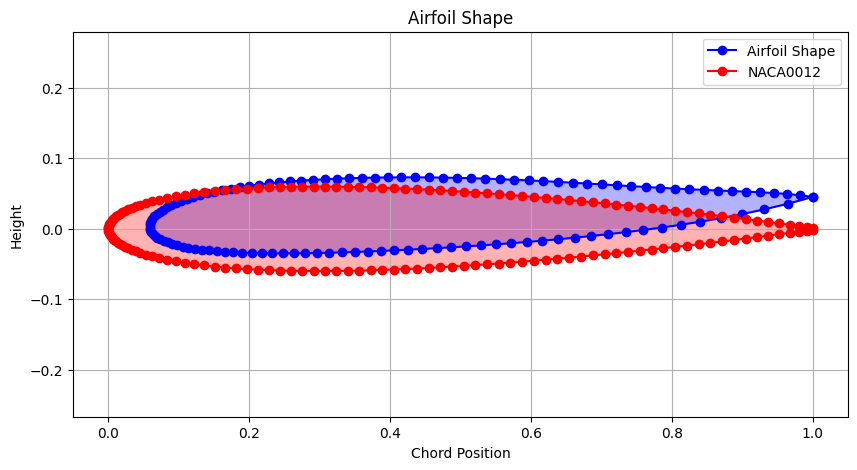

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.8188278675079346, drag : -0.011647938750684261
Direction 1.00, lift improvement -24.25%, drag improvement 22.23%


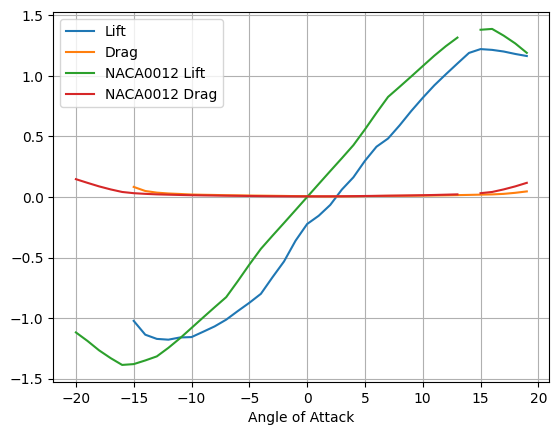

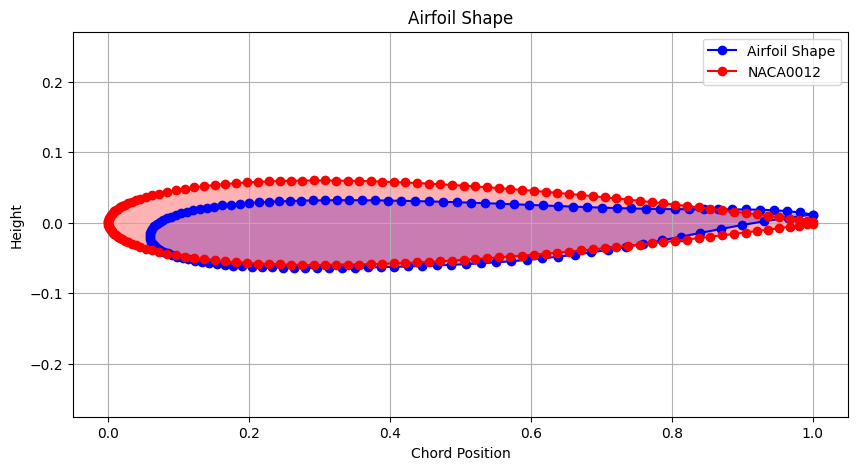

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.7299841642379761, drag : -0.011122997850179672
Direction 1.00, lift improvement -32.47%, drag improvement 25.73%


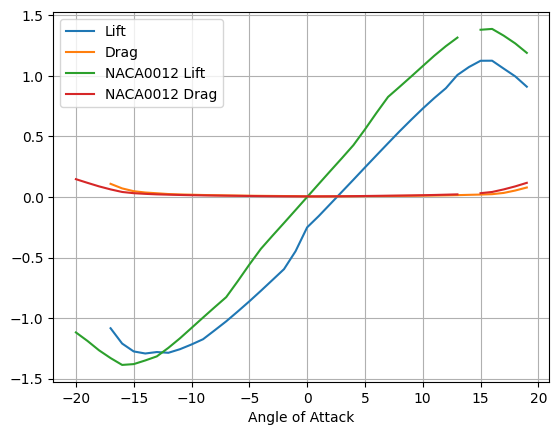

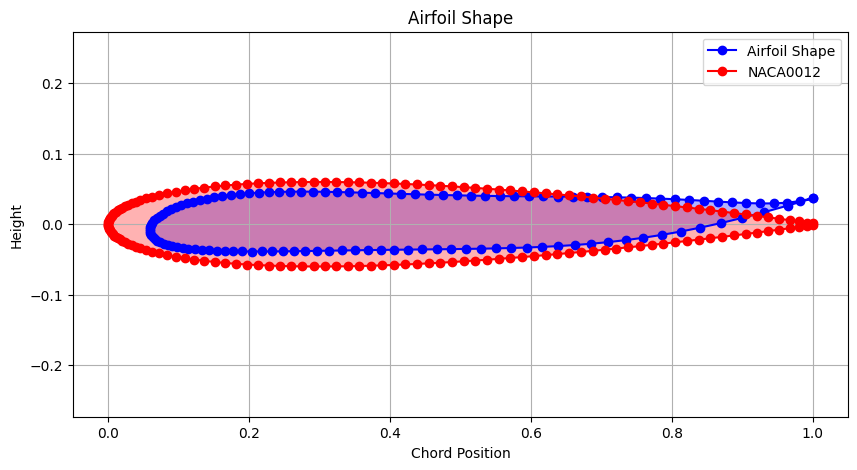

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.5080955624580383, drag : -0.009448781609535217
Direction 1.00, lift improvement -53.00%, drag improvement 36.91%


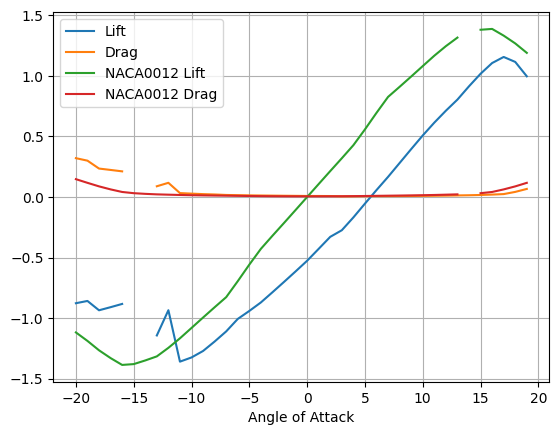

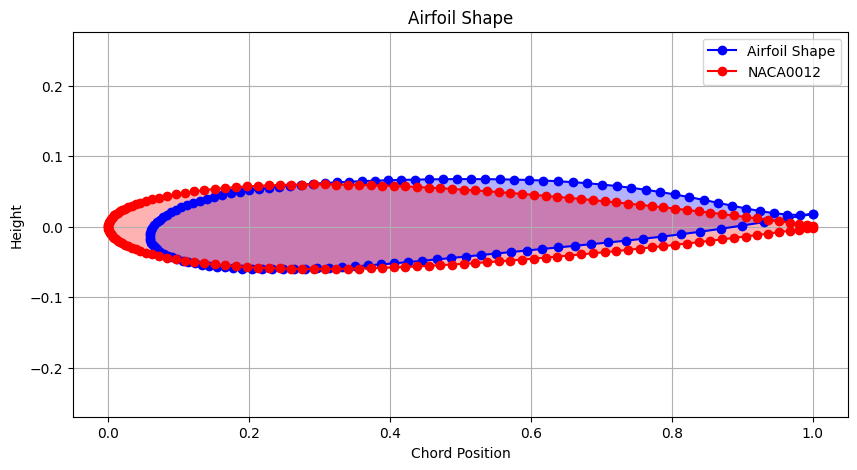

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.9818456172943115, drag : -0.01217689085751772
Direction 1.00, lift improvement -9.17%, drag improvement 18.70%


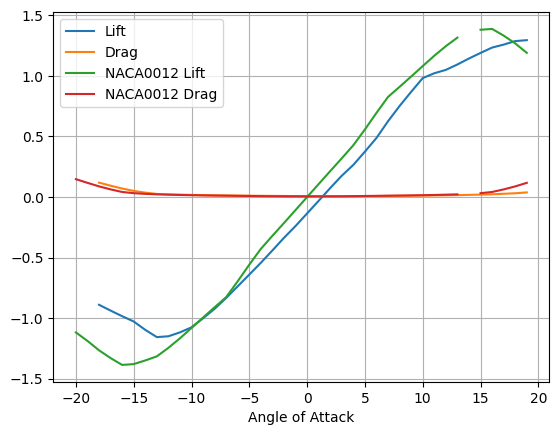

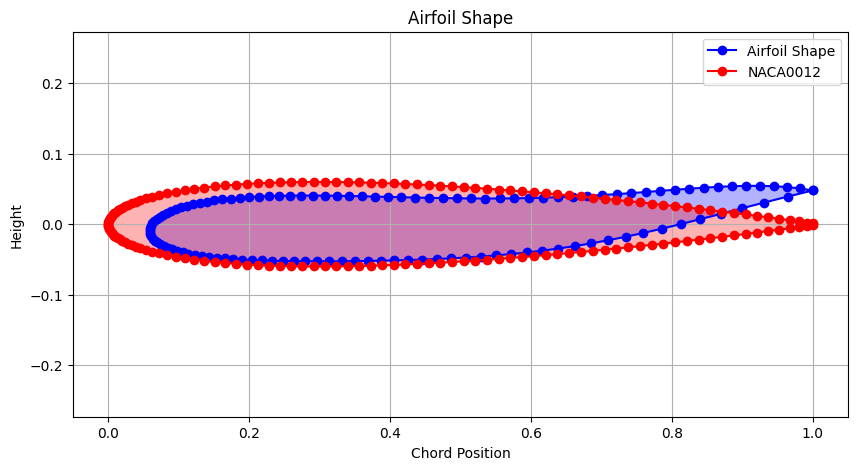

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.4396706521511078, drag : -0.008972866460680962
Direction 1.00, lift improvement -59.33%, drag improvement 40.09%


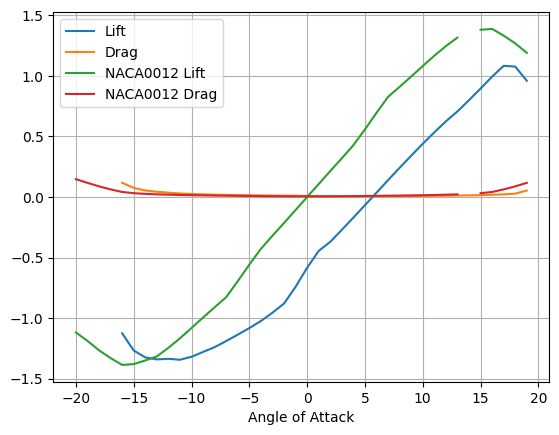

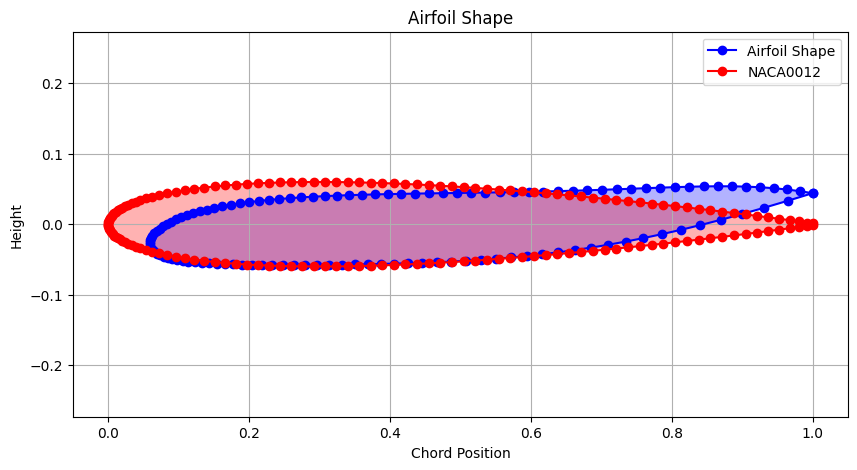

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.40768229961395264, drag : -0.008408821187913418
Direction 1.00, lift improvement -62.28%, drag improvement 43.86%


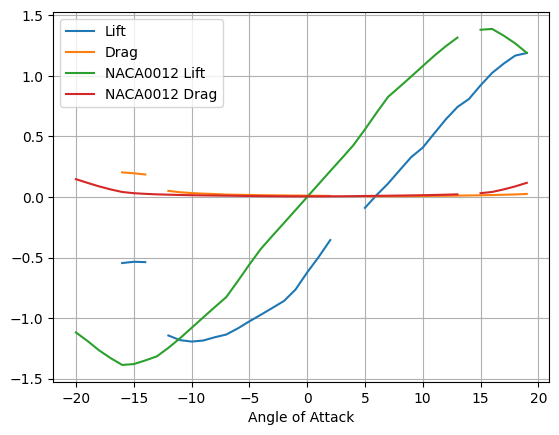

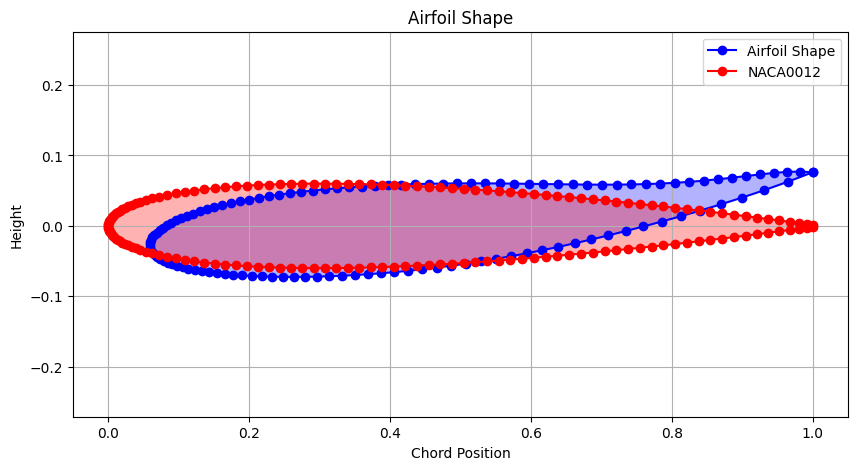

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 0.1249011754989624, drag : -0.006375607568770647
Direction 1.00, lift improvement -88.45%, drag improvement 57.43%


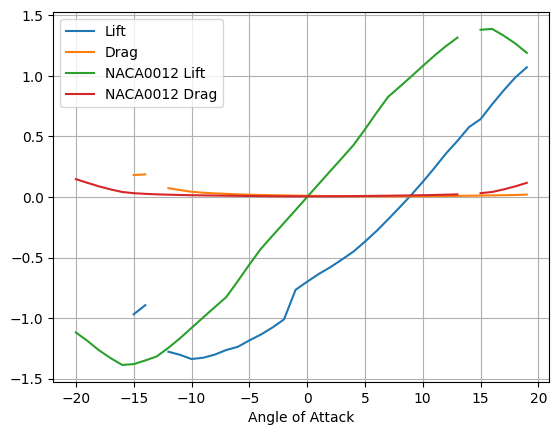

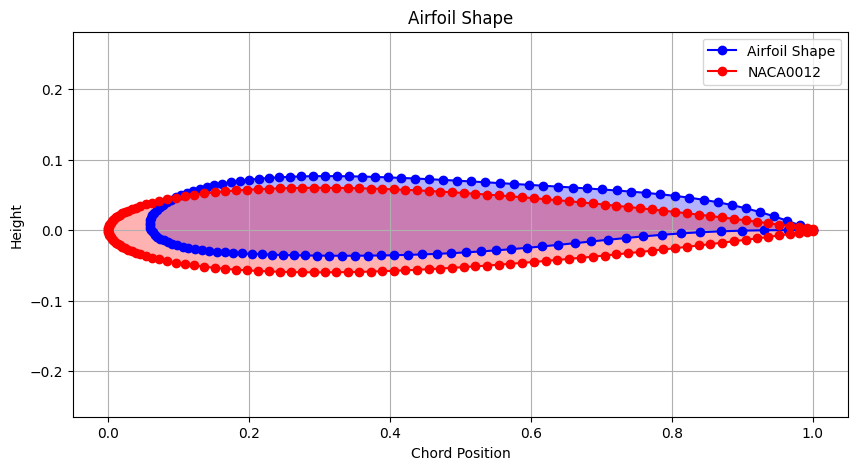

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 1.152530312538147, drag : -0.013817645609378815
Direction 1.00, lift improvement 6.62%, drag improvement 7.74%


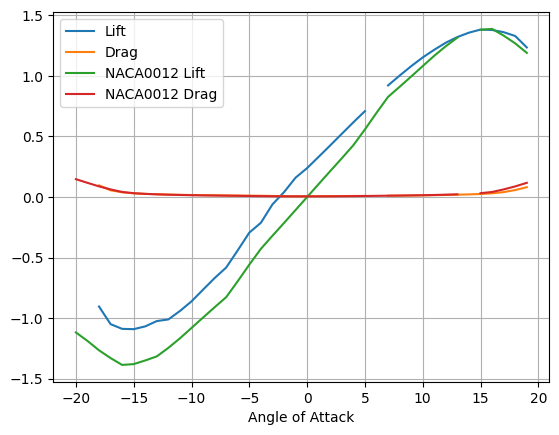

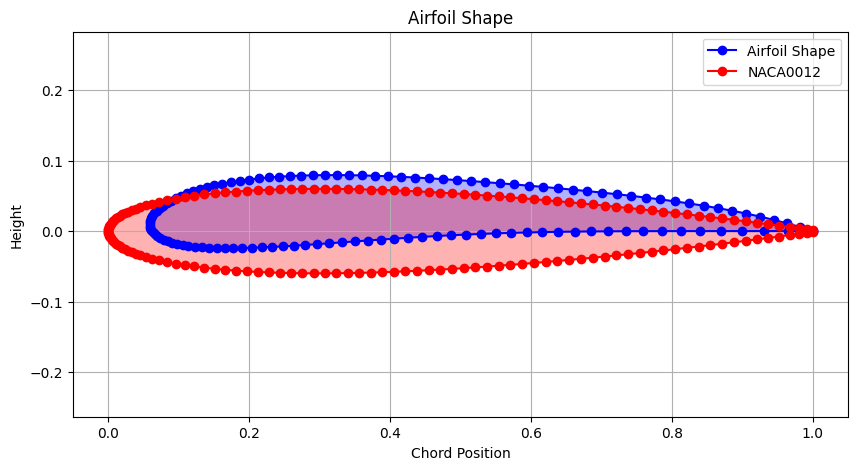

NACA0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
Best individual fitness : lift 1.2646058797836304, drag : -0.01423669420182705
Direction 1.00, lift improvement 16.99%, drag improvement 4.94%


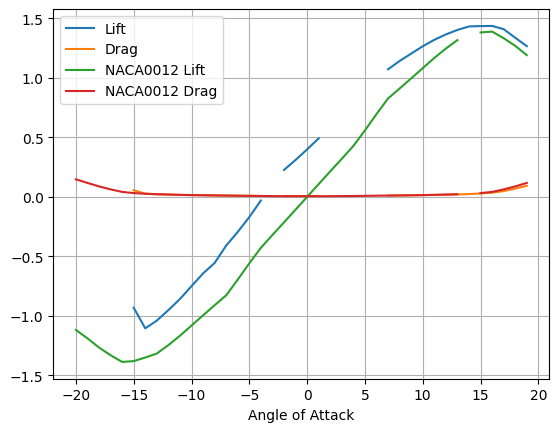

In [126]:
naca_a, naca_cl, naca_cd = naca_eval()

for i in pareto_indexes:
    if Y_sample[i][0] != 0 and Y_sample[i][1] != -1e5:
        ind = X_sample[i]
        fit = Y_sample[i]
        best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
        best, foil = airfoil(best_indiv, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)

        direction = fit[0] / abs(fit[0])
        naca0012_fit = np.array(fitness(naca0012))

        lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
        drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100

        plot_foil(best)
        a, cl, cd = evaluate_airfoil_angle_attacks(ind)

        plt.figure()
        plt.plot(a, cl, label="Lift")
        plt.plot(a, cd, label="Drag")
        plt.plot(naca_a, naca_cl, label="NACA0012 Lift")
        plt.plot(naca_a, naca_cd, label="NACA0012 Drag")
        plt.legend()
        plt.xlabel("Angle of Attack")
        plt.grid(True)

        print(f"NACA0012 fitness : lift {naca0012_fit[0]}, drag : {naca0012_fit[1]}")
        print(f"Best individual fitness : lift {fit[0]}, drag : {-fit[1]}")
        print(f"Direction {direction:.2f}, lift improvement {lift_improvement:.2f}%, drag improvement {drag_improvement:.2f}%")
